# Обучение GNN-модели на датасете графов

In [1]:
%load_ext autoreload
%autoreload 2

from src.data.hydrodataset import HydroDataset

import torch
torch.autograd.set_detect_anomaly(True)

from src.models.gnnprocessor import GNNProcessor
from src.visualization.visualize import visualize_graph
from src.models.train_model import HydraulicsLoss

from torch_geometric.nn import summary
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt

In [2]:
dataset = HydroDataset(root="/tmp/hydro")
train_ds = dataset[15:]
print("Dataset length:", len(train_ds))

Dataset length: 65


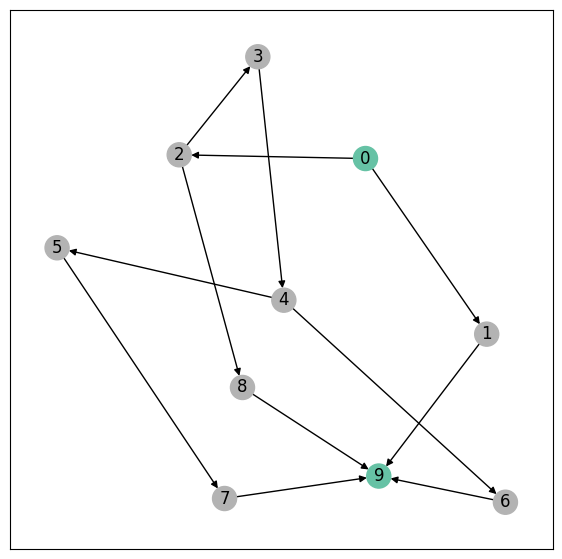

In [3]:
G = to_networkx(train_ds[1], to_undirected=False)
visualize_graph(G, color=dataset[0].x[..., 1] == 0);

In [4]:
loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [5]:
# initial settings: latent_dim=10, num_convs=20, convs_hidden_layers=[16],alpha_update_x=1.0

model = GNNProcessor(out_channels=1, 
                     num_edge_features=dataset.num_edge_features, 
                     latent_dim=64, 
                     num_convs=12, 
                     convs_hidden_layers=[64],
                     alpha_update_x=0.1,
                     aggr="mean")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

GNNProcessor(
  (convs): ModuleList(
    (0-11): 12 x GNNSConv(aggr=mean, latent_dim=64, alpha=0.1, hidden_layers=[64])
  )
  (final): Linear(in_features=64, out_features=1, bias=True)
  (balance_conv): BalanceConv()
)


In [6]:
criterion = HydraulicsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(pretrain_data=None):
  model.train()

  total_loss = 0
  for data in loader if pretrain_data is None else [pretrain_data]:
  
  #################################
  # for _ in range(1):
  #   data = train_ds[1]
  #################################

    data = data.to(device)
    optimizer.zero_grad()
    P, _, imbalance = model(data)
    loss = criterion(data, P, imbalance)    
    total_loss += loss.item() * data.num_graphs if pretrain_data is None else loss.item()
    # total_loss += loss.item()

    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
    optimizer.step()

  total_loss = total_loss / len(loader.dataset) if pretrain_data is None else total_loss

  return total_loss

In [7]:
# # pretrain the model
# for epoch in range(250):
#   loss = train(train_ds[0])
#   if (epoch % 10 == 0):
#     print(f'Pretraining epoch: {epoch:03d}, Loss: {loss:.4f}')   

In [8]:
# train
losses = []
for epoch in range(3000):
  loss = train()
  losses.append(loss)

  if (epoch % 10 == 0):
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}') 

Epoch: 000, Loss: 13125.4906
Epoch: 010, Loss: 3366.8437
Epoch: 020, Loss: 1096.9026
Epoch: 030, Loss: 2605.1179
Epoch: 040, Loss: 1325.2054
Epoch: 050, Loss: 3601.1528
Epoch: 060, Loss: 1358.2540
Epoch: 070, Loss: 878.5922
Epoch: 080, Loss: 4530.3393
Epoch: 090, Loss: 1382.6625
Epoch: 100, Loss: 815.6108
Epoch: 110, Loss: 844.0494
Epoch: 120, Loss: 949.4168
Epoch: 130, Loss: 4073.3046
Epoch: 140, Loss: 956.6739
Epoch: 150, Loss: 2357.9113
Epoch: 160, Loss: 806.8625
Epoch: 170, Loss: 1044.3609
Epoch: 180, Loss: 738.2246
Epoch: 190, Loss: 917.9939
Epoch: 200, Loss: 759.8533
Epoch: 210, Loss: 1543.9672
Epoch: 220, Loss: 711.5914
Epoch: 230, Loss: 773.0153
Epoch: 240, Loss: 694.7942
Epoch: 250, Loss: 711.6757
Epoch: 260, Loss: 713.9819
Epoch: 270, Loss: 723.2658
Epoch: 280, Loss: 1061.9257
Epoch: 290, Loss: 2094.7974
Epoch: 300, Loss: 1118.0443
Epoch: 310, Loss: 714.9383
Epoch: 320, Loss: 911.5106
Epoch: 330, Loss: 658.4666
Epoch: 340, Loss: 584.1588
Epoch: 350, Loss: 1246.3651
Epoch: 360

KeyboardInterrupt: 

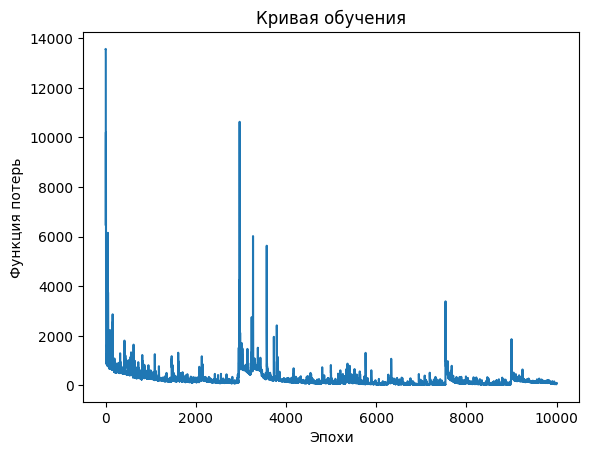

In [ ]:
plt.plot(losses)
plt.title('Кривая обучения')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь')
plt.show()

In [ ]:
losses

[13555.58046875,
 13558.299609375,
 13202.64921875,
 6447.115234375,
 9486.4880859375,
 10201.333203125,
 5313.5677734375,
 3845.44111328125,
 2929.86552734375,
 1653.1690185546875,
 1419.065869140625,
 1049.6856689453125,
 870.664453125,
 907.972119140625,
 930.5917724609375,
 1109.4509643554688,
 1167.0824951171876,
 1086.57861328125,
 1077.2844970703125,
 893.852734375,
 1019.3193603515625,
 1189.7312744140625,
 1053.881005859375,
 1073.2436279296876,
 1279.69541015625,
 1286.9849609375,
 1199.754638671875,
 1106.495166015625,
 1412.5607421875,
 1649.5772094726562,
 1511.5169311523437,
 1517.140283203125,
 1142.5660034179687,
 877.7602172851563,
 985.3461791992188,
 815.109423828125,
 792.17119140625,
 825.696484375,
 1062.577294921875,
 1160.3728515625,
 932.7596557617187,
 1305.6884033203125,
 1808.2968505859376,
 1309.653955078125,
 1075.2706420898437,
 902.5910034179688,
 2307.4236328125,
 1234.025927734375,
 4551.41787109375,
 6148.89208984375,
 3341.678564453125,
 1876.4187011

# Тестирование модели

In [ ]:
edge_index = torch.tensor([
  [0, 1, 2],
  [1, 2, 3]
], dtype=torch.long)

# Структура данных атрибутов вершин графа:
# Расход газа потребителя в узле, млн м3/сут; Давление газа, МПа
x = torch.tensor([[0, 7.4], [0.0, 0], [0, 0], [0, 5.4]], dtype=torch.float32)

# Структура данных атрибутов дуг графа:
# Протяженность, км; Внутренний диаметр трубы, мм
edge_attr = torch.tensor([
  [38, 1400],
  [40, 1400],
  [43, 1400]
])

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [ ]:
%%timeit
# %%timeit 
# Attention: При выводе значений давления краевые значения не выводятся, но учитываются в расчете
P, flows, imbalance = model(data)
print(f'{P=}')
print(f'{flows=}')
print(f'{imbalance=}')

P=tensor([[0.0000],
        [5.8063],
        [5.5281],
        [0.0000]], grad_fn=<ReluBackward0>)
flows=tensor([[  0.0000],
        [150.7678],
        [ 56.8801],
        [ 36.5575]], grad_fn=<ScatterAddBackward0>)
imbalance=tensor([[-150.7678],
        [  93.8877],
        [  20.3226],
        [  36.5575]], grad_fn=<SubBackward0>)
P=tensor([[0.0000],
        [5.8063],
        [5.5281],
        [0.0000]], grad_fn=<ReluBackward0>)
flows=tensor([[  0.0000],
        [150.7678],
        [ 56.8801],
        [ 36.5575]], grad_fn=<ScatterAddBackward0>)
imbalance=tensor([[-150.7678],
        [  93.8877],
        [  20.3226],
        [  36.5575]], grad_fn=<SubBackward0>)
P=tensor([[0.0000],
        [5.8063],
        [5.5281],
        [0.0000]], grad_fn=<ReluBackward0>)
flows=tensor([[  0.0000],
        [150.7678],
        [ 56.8801],
        [ 36.5575]], grad_fn=<ScatterAddBackward0>)
imbalance=tensor([[-150.7678],
        [  93.8877],
        [  20.3226],
        [  36.5575]], grad_fn=<SubB

In [ ]:
# import torch_geometric
# compiled = torch_geometric.compile(model)